<p style="font-size:14px; text-align: right">CoastWatch Python Exercises</p>  

# Create a virtual buoy from satellite data
> history | updated August 2021  
> owner | NOAA CoastWatch

## Background
There are buoys in many locations around the world that provide data streams of oceanic and atmospheric parameters. The data are often available through data centers like the National Data Buoy Center (NDBC https://www.ndbc.noaa.gov) and the ARGO floats program (http://www.argo.ucsd.edu). *In-situ* buoy data may not be available for your area of interest due to many factors that present challenges to maintaining long-term in-situ sensors. Using satellite data to create virtual buoys can offer a solution by providing surface environmental conditions at locations where it is not feasible to install a buoy. For example, the University of South Florida has developed a virtual buoy system for locations off the Florida coast (https://optics.marine.usf.edu/projects/vbs.html).  

## Overview 
The following exercise will demonstrate the use of the ERDDAP data server to create a virtual buoy from satellite sea surface temperature data. For this scenario, a virtual buoy is needed to continue the datastream for an *in situ* buoy that was discontinued at the end of 2019. For this exercise we will use the National Data Buoy Center (NDBC) buoy # 49259, which is located off the California coast at 34.767N latitude and -121.497E longitude, and pretend that it was discontinued at the end of 2019. The buoy measures several oceanic variables that are all discontinued, but we will demonstrate using satellite data to continue the sea surface temperature datastream forward. 
 
### Steps in the exercise   
1. __Create the virtual buoy using the ERDDAP server__  

2. __Bring the virtual buoy data into Python and visualize it__  

3. __Groundtruth the satellite data__
 * Download *in situ* buoy data and virtual buoy (satellite) data for the period from Jan. 2017 through Dec. 2019
 * Resample the buoy data to match the temporal resolution of the virtual buoy data
 * Run a linear regression to model the relationship between virtual buoy SST and *in situ* buoy SST data

4. __Plot the results__


### The exercise demonstrates the following skills:

* The use of ERDDAP to create a virtual buoy      
* The use of the Pandas module to import and manipulate data  
* Resampling data to bin into a lower resolution timestep 
* Generating a linear regression model and statistics
* Several approaches to plotting timeseries data  
* Cleaning data to remove outlying data points

## Import some required Python modules

In [24]:
import numpy as np
import xarray as xr
from datetime import datetime
import statsmodels.api as sm
import os
import pandas as pd
import io
import requests

np.warnings.filterwarnings('ignore')

## 1. CREATE THE VIRTUAL BUOY  

We can make a virtual buoy from satellite data very quickly online using ERDDAP's web visualization (make a graph) interface.   
### Selecting a satellite dataset 

One satellite dataset for sea surface temperature (SST) is the NOAA GeoPolar Blended SST dataset (ERDDAP ID: nesdisGeoPolarSSTN5SQNRT). It blends together many satellite sensors to obtain good daily coverage of the globe, and then uses an interpolation method to fill in spatial data gaps. 

Use a web browser to go to ERDDAP's visualization page for the GeoPolar Blended SST dataset:  
https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.graph. 

We will create a virtual buoy at the location of an NDBC buoy to compare the buoy timeseries of the satellite data timeseries. The NBDC buoy is located at 34.767N latitude and the -121.497E longitude, so we will use those coordinates to view and download data from ERDDAP. 

*For an introduction to the ERDDAP data server, please see this online tutorial: 
https://github.com/CoastWatch-WestCoast/ERDDAP-basics/blob/master/Readme.md*

### Generating a time-series of satellite data
__Using the ERDDAP visualization interface, do the following:__  
* Set the `Graph Type` to linesAndMarkers
* Set the `X Axis` to `time` and the `Y Axis` to `analysed_sst`
* On the time (UTC) widget, set ` Start` to Jan. 1, 2020 (`2020-01-01T12:00:00Z`) and `Stop` to the most recent date (`2020-04-01T12:00:00Z` at the time time of this writing).
* Set the `latitude (degrees_north)` to `34.767`, the latitude of our buoy, and the `longitude (degrees_east)` to `-121.497`, the longitude of our buoy. 
* Click `Redraw the Graph`  


The data for the virtual buoy will be displayed in the interface:
<img src="https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.png?analysed_sst%5B(2020-01-01T12:00:00Z):(2020-04-01T12:00:00Z)%5D%5B(34.775)%5D%5B(-121.475)%5D&.draw=linesAndMarkers&.vars=time%7Canalysed_sst%7C&.marker=5%7C5&.color=0x000000&.colorBar=%7C%7C%7C%7C%7C&.bgColor=0xffccccff">

### You are finished making a virtual buoy!   

* This is your virtual buoy. You have extracted satellite data at the location of your buoy and plotted a time-series of the satellite sst at this location. 
* For this exercise we wil bring the data into Python to go through some validation steps and make better plots.  


## 2. BRING VIRTUAL BUOY DATA INTO PYTHON AND VISUALIZE IT
Next we will download the satellite SST virtual buoy data directly from ERDDAP and into Python. First we will get the url to the data from the using the ERDDAP web interface. Then we will use the url to request the data in csv format and load it into pandas.   

### Generate the ERDDAP data request URL for the satellite data   
* Go to the ERDDAP visualization page where you created the virtual buoy in Step 1. 
(https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.graph?analysed_sst[(2020-01-01T12:00:00Z):(2020-04-01T12:00:00Z)][(34.775)][(-121.475)]&.draw=linesAndMarkers&.vars=time|analysed_sst|&.marker=5|5&.color=0x000000&.colorBar=|||||&.bgColor=0xffccccff)  


* Near the top of the ERDDAP interface, click the `Data Access Form` link. 
* The ERDDAP `Data Access Form` page allows you to refine your data request. Our goal on this page is to obtain the data request URL to download the data as a __.CSV__ file. 
* Use the `File type:` dropdown and select `.csv`. Then click on the `Just generate the URL` button.
* Copy the url link that appears in the box to the right of the button. 

__The generated data request URL should look like this:__   
>https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.csv?analysed_sst[(2020-01-01T12:00:00Z):1:(2020-04-01T12:00:00Z)][(34.775):1:(34.775)][(-121.475):1:(-121.475)]   

__Getting the most up-to-date data__  
Using the `last` function to always request the latest data:
* We can use an ERDDAP feature to set the end date to be the most recent date available instead of hardcoding an actual date. 
* At the time this tutorial was written, the most recent data available was from `2020-04-01T12:00:00Z` (April 1, 2020). 
* By changing the end date (`2020-04-01T12:00:00Z`) to `last`, you will request to most recent data. 
* The new URL looks like the following:  
>https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.csv?analysed_sst[(2020-01-01T12:00:00Z):1:(last)][(34.775):1:(34.775)][(-121.475):1:(-121.475)]  

__Bring the data into a Pandas data frame__  
* You could put this URL directly into a browser and the CSV data file would download to your computer.
* We will use the url to bring the csv data into Python as a Pandas data frame.

### Create a python function to load the CSV data into Pandas  
* We will be making several requests to the ERDDAP server for CSV data that we will put into Pandas data frames. 
* Creating a function will save repeating the same code over again. 
* Here we create a `get_csvdata` function. 
* Pass this function the ERDDAP file url and it will return the data in a pandas data frame.   

In [25]:
def get_csvdata(erddapURL):
    
    '''
    The requests module allows you to send a HTTP (URL) request,
    that returns a Response Object with all the response 
    data (content, encoding, status...)
    '''
    response = requests.get(erddapURL).content
    
    '''
    The StringIO class of the io module creates a file-like object 
    or memory file from the request response. 
    
    The decode function decodes the request response from 
    its 'utf-8' URL encoding.
    
    The Pandas (pd) read_csv function imports the csv data 
    from the request response into a Pandas dataframe. 
    
    A CSV file from ERDDAP has the column headers in the 
    first row and the units in the second row. The read_csv 
    function assumes the header is on the first row. 
    skiprows=[1] (below) tells read_csv to import row 0 as the header, 
    then skip row 1 and import the data starting on row 2.
    '''
    my_df = pd.read_csv(io.StringIO(response.decode('utf-8')), skiprows=[1])
    
    return my_df

### Get the satellite virtual buoy data
* Call the get_csvdata function with the ERDDAP URL
* It may take a while to retrieve the csv file, depending on your data request size and your network bandwidth.
* The data are reurned as a pandas data frame
* The first lines of the data frame will print once the data is retrieved

In [27]:
erddap_data_request = 'https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.csv?analysed_sst[(2020-01-01T12:00:00Z):1:(2021-01-01T12:00:00Z)][(34.775):1:(34.775)][(-121.475):1:(-121.475)]'

vir_buoy_df = get_csvdata(erddap_data_request)

vir_buoy_df.head()

,time,latitude,longitude,analysed_sst
0,2020-01-01T12:00:00Z,34.775,-121.475,14.089994
1,2020-01-02T12:00:00Z,34.775,-121.475,13.839994
2,2020-01-03T12:00:00Z,34.775,-121.475,13.789994
3,2020-01-04T12:00:00Z,34.775,-121.475,14.009994
4,2020-01-05T12:00:00Z,34.775,-121.475,13.869994


### Prepare the virtual buoy data for analysis and plotting  
Clean up a bit. Put the lat/lon values into a dictionary and remove the latitude and longitude columns which are repetitive since we are looking at one single location. 

1. Create the dictionary with the location
2. Remove the latitude and longitude columns from the data frame with the Panda drop() function. 
    * The drop() function removes rows or columns by specifying label names and the axis containing the labels.    
    * The first argument is the column to drop, by name. 
    * The axis argument indicates if the name is a `row` (0) or a `column` (1). 
    * The argument inplace=True argument applies the row or column deletion to the data frame in use (e.g. vir_buoy_df in this case). By default (inplace=False), a new dataframe would be created.  


In [28]:
# location of the buoy 
buoy_location = {'lat':vir_buoy_df.iloc[ 1 , : ].loc['latitude' ],
                 'lon':vir_buoy_df.iloc[ 1 , : ].loc['longitude' ]
                }

# Drop the latitude and longitude columns
vir_buoy_df.drop('latitude', axis=1, inplace=True)
vir_buoy_df.drop('longitude', axis=1, inplace=True)
vir_buoy_df.head()

,time,analysed_sst
0,2020-01-01T12:00:00Z,14.089994
1,2020-01-02T12:00:00Z,13.839994
2,2020-01-03T12:00:00Z,13.789994
3,2020-01-04T12:00:00Z,14.009994
4,2020-01-05T12:00:00Z,13.869994


## Visualize the virtual buoy data 
Use the matplotlib python library. There are many ways to use matplotlib to plot data. Below is a simple approach. 
>Documentation for matplotlib can be found here: https://matplotlib.org

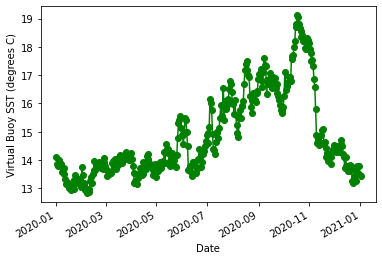

In [29]:
#Import the needed modules
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# the %matplotlib is a magic function that allows displaying results in notebooks
%matplotlib inline

# some tools for Pandas to work well with matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Create the figure and give it a size
fig = plt.figure(figsize=(6, 4))

# add a subplot
ax = fig.add_subplot()

# Assign the x and y data, 
#    i.e. pd.to_datetime(vir_buoy_df.time), vir_buoy_df.analysed_sst
#    pd.to_datetime changes the datestamp into a date objest
# Design the look of the plots
#    color the plot, color='green'
#    define the marker shape: marker='o' is a filled circle
#        e.g. '+' are pluses
#    define the line type shape: linestyle='-'
#        e.g. '--' is dashed, '-.' is dash-dot
ax.plot(pd.to_datetime(vir_buoy_df.time), vir_buoy_df.analysed_sst,
        color='green', marker='o', linestyle='-')

# format the date for the x axis and autoformat
ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')

# set the axis labels
ax.set_xlabel("Date")
ax.set_ylabel("Virtual Buoy SST (degrees C)")
fig.autofmt_xdate()


## 3. GROUNDTRUTH VIRTUAL BUOY MEASUREMENTS
How confident are we that the satellite SST measurements are similar to the *in situ* SST buoy measurements? Validating or groundtruthing the virtual buoy data is an important step to understand the accuracy of the data. Since both the *in situ* and the satellite data extend back in time before 2020, we can compare a few years of data (2017-2019) from both data streams to see how well they correlate.    

We will do the following to compare the two data streams:
* Load new data from NDBC buoy #49259 for the time period between Jan 1, 2017 and December 31, 2019.  
* Download data from the satellite SST dataset for the same time period.  
* Evaluate, both visually and statistically, how the two data streams compare to one another.  

### Load 2017-2019 NDBC buoy data
 
For this portion of the training, we have created a .csv file of the buoy data from 2017-2019 (buoy_49259_2016_2019.csv).  The buoy data was downloaded from the NDBC website. You can see the python code for that data download in Appendix A below.  

* Load the buoy data file into a Pandas data frame and preview it. This may take a while - the csv file is 1.2 MB.


In [5]:
buoy_data = pd.read_csv('../data/buoy_46259_2017_2019.csv', parse_dates=['Time'])

print('# of timesteps =', buoy_data.shape[0] )
buoy_data.head()


# of timesteps = 50900


,Time,WTMP_degC
0,2017-01-01 00:00:00,13.1
1,2017-01-01 00:30:00,13.0
2,2017-01-01 01:00:00,13.0
3,2017-01-01 01:30:00,13.0
4,2017-01-01 02:00:00,13.0


### Plot the full resolution *in-situ* buoy data  
This plot uses the plot() function, which is an integration of the `matplotlib` library into Pandas.

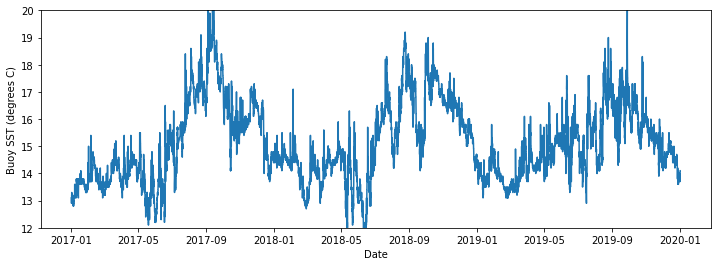

In [12]:
plt.figure(figsize=(12, 4))
plt.ylim(12, 20)
plt.xlabel("Date")
plt.ylabel("Buoy SST (degrees C)")
plt.plot(buoy_data.Time, buoy_data.WTMP_degC)

### Resample the *in situ* buoy data
The sampling resolution for the buoy data is 30 minutes. However, the temporal resolution for the satellite dataset is daily. Pandas makes it easy the downsample the 30 minute buoy data to create daily bins of the data that match the temporal resolution of the satellite.   

Use the Pandas `resample` method (below) to generate daily means.  
* The "D" is the resampling rule that sets the resampling interval. Here, "D" indicates resampling into daily bins. Similarly, using "3D" would resample into three-day bin and "M" would resample into monthly bins. 
* `on='Time'` identifies the column with the Pandas datetime data.  
* `.mean()` defines the math operation to be preformed on the daily bins.
* An overview of the resample method can be found here: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#resampling  

In [13]:
print('# of timesteps before =', buoy_data.shape[0] )

buoy_data_resampled = buoy_data.resample('D', on='Time').mean()
print('# of timesteps after =', buoy_data_resampled.shape[0] )

buoy_data_resampled.head()

# of timesteps before = 50900
# of timesteps after = 1095


,WTMP_degC
Time,
2017-01-01,13.120833
2017-01-02,13.110417
2017-01-03,12.970833
2017-01-04,12.912500
2017-01-05,12.968750


*Note 1: The resampled data frame (above) contains mean daily values. The "Time" column is now the index (first) column and it is in the Timestamp (datetime64) format.*   

*Note 2: The length of the data frame (# of time steps) is 1095.*   

### Clean up the *in-situ* data
The data is likely to contain data points that are outliers or that contain no data. Let's remove those points from the data frame. 
* Apply a conservative allowable data range. 
 * For the lower end of the range, the freezing point of seawater (ca. -2).  
 * For the high end of the range, value unlikely to be seen in the area of interest (e.g. 45 degrees C). 

In [14]:
# Get # of timesteps before cleaning
b4 = buoy_data_resampled.shape[0] 
print('# of timesteps before cleaning =', b4 )

# Extract the temperature data into a data frame
y = buoy_data_resampled['WTMP_degC']

# Find the data that is within our acceptable range
removed_outliers = y.between(-2, 45)

# Invert the results of removed_outliers to get the 
#   indices of the values outside of the acceptable range 
index_names = buoy_data_resampled[~removed_outliers].index

# Drop values outside of the acceptable range from the data frame 
buoy_data_resampled.drop(index_names, inplace=True)
print('# of timesteps after cleaning =', buoy_data_resampled.shape[0] )
print(b4-buoy_data_resampled.shape[0], 'time steps were removed')
# buoy_data_resampled.head()

# of timesteps before cleaning = 1095
# of timesteps after cleaning = 1091
4 time steps were removed


__Note that the length of the data frame (# of time steps) went from 1095 to 1091, i.e. four timesteps were outside of the acceptable time range, and they were removed__.    


### Plot the cleaned and downsampled *in situ* buoy data 


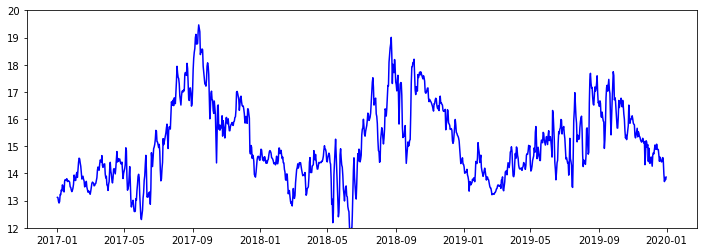

In [15]:
plt.figure(figsize=(12, 4))

plt.ylim(12, 20)
plt.plot(buoy_data_resampled.index, buoy_data_resampled.WTMP_degC, "b")

# plt.plot(pd.to_datetime(c.time), c.analysed_sst, 'ro', buoy_data_resampled.time_oj, buoy_data_resampled.WTMP_degC)

<AxesSubplot:xlabel='Time'>

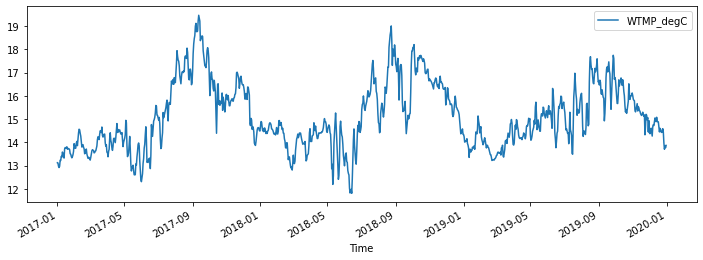

In [16]:
buoy_data_resampled.plot(figsize=(12, 4))

### Download satellite data from the NOAA GeoPolar Blended SST dataset
Download the satellite SST data for 2017-2019 using the same SST NOAA GeoPolar Blended SST product.



#### Look at the satellite product's metadata

Query ERDDAP for information about the satellite dataset. ERDDAP has a feature that allows you to select and download metadata about any and all datasets in that ERDDAP. Click the link below to bring up the user interface for this feature: https://coastwatch.pfeg.noaa.gov/erddap/tabledap/allDatasets.html. The metadata values can be downloaded via a URL-based data request. Details about this feature are presented in tutorial #1. For the purposes of this exercise, it is enough to know that we are pulling the metadata from this page into a CSV file and using it in Python.

Next we will build a function to harvest metadata from ERDDAP. It builds the URL data request, sends a request to ERDDAP for the metadata, and loads the results into a Pandas data frame. It uses the `xarray` module in OpenDAP mode to obtain a list of data variables.

Inputs are:  

* The location of the ERDDAP server on the Internet: The NOAA GeoPolar blended SST dataset can be found on the CoastWatch West Coast Node ERDDAP at this URL: https://coastwatch.pfeg.noaa.gov/erddap  


* The unique ERDDAP ID for the dataset: For the NOAA GeoPolar blended SST dataset the ID is nesdisGeoPolarSSTN5SQNRT

In [17]:
# Variable containing the WCN ERDDAP URL
my_erddap_location = 'https://coastwatch.pfeg.noaa.gov/erddap'

# The dataset ID for NOAA GeoPolar blended SST 
my_ds_ID = 'nesdisGeoPolarSSTN5SQNRT'

# A function to form the metadata request URL and 
# download the metadata into a Pandas data frame
def get_dataset_info(erddapURL, datasetID):
    queryURL = "".join(['?datasetID,minLongitude,maxLongitude,longitudeSpacing,minLatitude,maxLatitude,latitudeSpacing,', 
                        'minAltitude,maxAltitude,', 
                        'minTime,maxTime,timeSpacing,griddap&datasetID="'])
    
    # Form the base URL leading to the allDatasets page
    baseURL = '/'.join([erddapURL, "tabledap", "allDatasets.csv"])
    
    # Form the data query part of the URL. 
    # For this exercise we will only request: 
    # 1) dataset ID, 
    # 2) the minimum and maximum longitude, and the distance between values, 
    # 3) the minimum and maximum latitude, and the distance between values
    # 4) the minimum and maximum altitude values
    # 5) the minimum and maximum dates, and the distance between time values
    fullURL = ''.join([baseURL, queryURL, datasetID,'"'])
    
    s=requests.get(fullURL).content
    c=pd.read_csv(io.StringIO(s.decode('utf-8')), skiprows=[1])
    
    #print(c.griddap[0])
    # get the data variables using xarray via OpenDAP 
    c['variables'] = [list(xr.open_dataset(c.griddap[0]).data_vars)]
    return c


__Run the get_dataset_info function and view the results__ 

In [18]:
dataset_info = get_dataset_info(my_erddap_location, my_ds_ID)

display(dataset_info.loc[:, 'datasetID':'latitudeSpacing'])
display(dataset_info.loc[:, 'minAltitude':'timeSpacing'])
display(dataset_info.loc[:, 'griddap':'variables'])

print("Metadata helpful for this project are listed below")
print(" ")
print('Time Range:', dataset_info.minTime[0][:10], 'to', dataset_info.maxTime[0][:10] )
print('Data Variables:', dataset_info.variables[0] )
print('Direct dataset URL:', dataset_info.griddap[0]) 

,datasetID,minLongitude,maxLongitude,longitudeSpacing,minLatitude,maxLatitude,latitudeSpacing
0,nesdisGeoPolarSSTN5SQNRT,-179.975,179.975,0.05,-89.975,89.975,0.05


,minAltitude,maxAltitude,minTime,maxTime,timeSpacing
0,NaN,NaN,2002-09-01T12:00:00Z,2022-01-10T12:00:00Z,86485.617214


,griddap,variables
0,https://coastwatch.pfeg.noaa.gov/erddap/gridda...,"[analysed_sst, analysis_error, sea_ice_fractio..."


Metadata helpful for this project are listed below
 
Time Range: 2002-09-01 to 2022-01-10
Data Variables: ['analysed_sst', 'analysis_error', 'sea_ice_fraction', 'mask']
Direct dataset URL: https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT


### Get the ERDDAP data request URL for the satellite data
There are two options to get the ERDDAP data request URL for the data:  
 
__Option 1.__ Use the the ERDDAP interface like we did above in section 2: This is quick but is not usable for automating scripts to download data.  

* Go back to the `Data Access Form` page (https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.html) where you can refine your data request. Our goal on this page is to obtain the data request URL to download the data for 2017-2019 as a CSV file. 
* Find the `File type:` dropdown and select `.csv`. Then push the "Just `generate the URL button` and copy the link in the box to the right for th button. 
>
>The data request URL should look like the following URL:  
>https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.csv?analysed_sst[(2017-01-01T12:00:00Z):1:(2019-12-31T12:00:00Z)][(34.775):1:(34.775)][(-121.475):1:(-121.475)]

__Option 2.__ Develop a function in Python to generate the data request URL:   

To develop the function, use the URL obtained in Option 1 as a model, and break it down into its components. We will generate the components within Python and then put them together to create the URL.

The URL components  
>1. The direct URL to the dataset: https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT
Get this from our dataset_info data frame as `dataset_info.griddap`
2. The type of file we want to download: `.csv?`  
3. The variable of interest (`analysed_sst`). We can type the name in or get this from our dataset_info data frame as `dataset_info.griddap`  
4. The time range: (`[(2017-01-01T12:00:00Z):1:(2019-12-31T12:00:00Z)]`). Get the time values from the maximum and minimun date/time values in the buoy_data data frame. i.e. buoy_data["Time_iso"].values.min() and buoy_data["Time_iso"].values.max()        
5. The latitude range: `[(34.775):1:(34.775)]`. Get these values from the `buoy_location` dictionary, i.e. buoy_location['lat']    
6. The longitude range:`[(-121.475):1:(-121.475)]`. Get these values from the `buoy_location` dictionary, i.e. buoy_location['lon']   

#### The function for Option 2 is below: 


In [19]:
def make_erddap_url(my_var, ds_info_df, buoy_lt_ln, buoy_df):

    # my_var is the data variable of interest, 
    #    which is 'analysed_sst' in this example
    # ds_info_df is the dataset_info data frame that 
    #    we generated with the get_dataset_info() function
    
    maxTime = datetime.strftime(buoy_df.index.max(), '%Y-%m-%dT%H:%M:%SZ')
    minTime = datetime.strftime(buoy_df.index.min(), '%Y-%m-%dT%H:%M:%SZ')

    import math
    st = '[('
    ed = ')]'
    md = '):('
    url_1 = ''.join([dataset_info.griddap[0], '.csv?', my_var,
             st, minTime, md,
             #buoy_data_resampled["Time_iso"].values.max(), ed])
             maxTime, ed]) 

    # Check for inverted lat
    url_lat = ''.join([st, str(buoy_lt_ln['lat']), ed]) 
    url_lon = ''.join([st, str(buoy_lt_ln['lon']), ed])

    if math.isnan(ds_info_df.minAltitude[0]):
        # print('1')
        my_url = ''.join([url_1, url_lat, url_lon])
        # print(my_url)
    else:
        # print('2')
        url_alt = ''.join([st, str(ds_info_df.minAltitude[0]), ed]) 
        my_url = ''.join([url_1, url_lat, url_lon])
        my_url
        # print(my_url)
    
    return my_url

### Create the ERDDAP data request URL for the satellite data

In [37]:
erddap_url = make_erddap_url('analysed_sst', dataset_info, buoy_location, buoy_data_resampled)
erddap_url

'https://coastwatch.pfeg.noaa.gov/erddap/griddap/nesdisGeoPolarSSTN5SQNRT.csv?analysed_sst[(2017-01-01T00:00:00Z):(2019-12-31T00:00:00Z)][(34.775)][(-121.475)]'

### Use the URL into our get_csvdata() function to get the satellite data
The function reaches out to ERDDAP to download the data.  
__Note: Be patient. Downloading may take a while, depending on your internet speed.  
Note: If you get an error, then run function again. The server probably timed out__

In [30]:
sat_data = get_csvdata(erddap_url)
sat_data.head()

,,Error {
"message=""Internal Server Error: There was a (temporary?) problem. Wait a minute",then try again. (In a browser,click the Reload button.)
(ERROR from data source: java.lang.RuntimeException: ERROR in getPrimitiveArrays for query=?analysed_sst%5B5236:5960%5D%5B2495:2495%5D%5B1170:1170%5D,NaN,NaN
Connection cannot be read https://www.star.nesdis.noaa.gov/thredds/dodsC/BlendedSST5kmNightAggGHRSSTLoM.dods?analysed_sst%5B5236:5960%5D%5B2495:2495%5D%5B1170:1170%5D),NaN,NaN
(Cause: java.lang.RuntimeException: ERROR in getPrimitiveArrays for query=?analysed_sst%5B5236:5960%5D%5B2495:2495%5D%5B1170:1170%5D,NaN,NaN
"Connection cannot be read https://www.star.nesdis.noaa.gov/thredds/dodsC/BlendedSST5kmNightAggGHRSSTLoM.dods?analysed_sst%5B5236:5960%5D%5B2495:2495%5D%5B1170:1170%5D)"";",NaN,NaN


### Clean up the satellite data
The satellite data may contain data points that are outliers or that contain no data. Let's look for outliers and remove those points from the data frame if they exist. 
* Apply a conservative allowable data range. 
 * For the lower end of the range, the freezing point of seawater (ca. -2).  
 * For the high end of the range, value unlikely to be seen in the area of interest (e.g. 45 degrees C). 

In [22]:
# Get the number of timesteps before cleaning
b4 = sat_data.shape[0] 
print('# of timesteps before cleaning =', b4 )

# Extract the temperature data into a data frame
y = sat_data['analysed_sst']

# Find the data that is within our acceptable range
removed_outliers = y.between(-2, 45)

# Invert the results of removed_outliers to get the 
#   indices of the values outside of the acceptable range 
index_names = sat_data[~removed_outliers].index # INVERT removed_outliers!!

# Drop values outside of the acceptable range from the data frame 
sat_data.drop(index_names, inplace=True)
sat_data.shape

print('# of timesteps after cleaning =', sat_data.shape[0] )
print(b4-sat_data.shape[0], 'times were removed')
sat_data.head()


# of timesteps before cleaning = 6


KeyError: 'analysed_sst'

### Prepare the timestamps
Edit the 'time' column to match buoy time format and move 'time' to the index location 

In [46]:
# Put the time column into datetime64 format
sat_data['time'] = pd.to_datetime(sat_data['time'], errors='coerce')

# Cut time part of datetime and put into new column "Time"
sat_data['Time'] = sat_data['time'].dt.date

# Put the Time column into datetime64 format
sat_data['Time'] = pd.to_datetime(sat_data['Time'])

# Make the index column the time column
sat_data.set_index('Time', inplace=True)
sat_data.head()

,time,latitude,longitude,analysed_sst
Time,,,,
2017-01-01,2017-01-01 12:00:00+00:00,34.775,-121.475,12.859994
2017-01-02,2017-01-02 12:00:00+00:00,34.775,-121.475,12.949994
2017-01-03,2017-01-03 12:00:00+00:00,34.775,-121.475,12.979994
2017-01-04,2017-01-04 12:00:00+00:00,34.775,-121.475,12.819994
2017-01-05,2017-01-05 12:00:00+00:00,34.775,-121.475,12.779994


### Trim buoy and satellite data to the times present in both datasets

In [47]:
# keep only the buoy_data_resampled times that are in sat_data
print ('Timesteps before in buoy data =', buoy_data_resampled.shape[0])
buoy_data_final = buoy_data_resampled[buoy_data_resampled.index.isin(sat_data.index)]
print ('Timesteps after in buoy data =', buoy_data_final.shape[0])

# keep only the sat_data times that are in buoy_data_final
print ('Timesteps before in sat data =', sat_data.shape[0])
sat_data_final = sat_data[sat_data.index.isin(buoy_data_final.index)]
print ('Timesteps after in sat data =', sat_data_final.shape[0])

Timesteps before in buoy data = 1091
Timesteps after in buoy data = 1085
Timesteps before in sat data = 1089
Timesteps after in sat data = 1085


### Generate a linear regression of satellite vs. *in-situ* buoy data

In [48]:
import statsmodels.api as sm
#Y1 = np.array(buoy_data_final.WTMP_degC)
Y1 = np.array(sat_data_final.analysed_sst)
#X1 = np.array(sat_data_final.analysed_sst)
X1 = np.array(buoy_data_final.WTMP_degC)
X1_b=sm.add_constant(X1)
model = sm.OLS(Y1, X1_b, missing='drop')
results = model.fit()


print('Y-Intecept: ', results.params[0])
print('Slope: ', results.params[1])
print('R2: ', results.rsquared)

results.summary()

Y-Intecept:  0.5298046099717714
Slope:  0.9558409867765578
R2:  0.9216794169492041


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                 1.274e+04
Date:                Sat, 14 Aug 2021   Prob (F-statistic):               0.00
Time:                        15:59:15   Log-Likelihood:                -519.16
No. Observations:                1085   AIC:                             1042.
Df Residuals:                    1083   BIC:                             1052.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5298      0.128      4.127      0.000       0.278       0.782
x1             0.9558      0.008    112.893      0.000       0.939       0.972
==============================================================================
Omnibus:                       31.741   Durbin-Watson:                   0.750
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.392
Skew:                          -0.177   Prob(JB):                     4.67e-14
Kurtosis:                       4.111   Cond. No.                         165.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 4. Plot the two years of satellite and buoy data

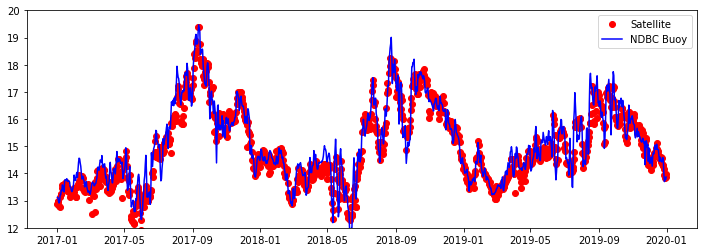

In [49]:
plt.figure(figsize=(12, 4))

# set the minimun and maxium for the y axis
plt.ylim(12, 20)

# set the plot.
# The "ro" indicates a red filled circular marker. The "b" indicates a blue line.
plt.plot(sat_data_final.index, sat_data_final.analysed_sst, "ro", label="Satellite")
plt.plot(buoy_data_final.index, buoy_data_final.WTMP_degC, "b", label="NDBC Buoy")
plt.legend(loc="upper right")
#plt.plot(sat_data_final.index, sat_data_final.analysed_sst, "ro", buoy_data_final.index, buoy_data_final.WTMP_degC, "b")

### Plot satellite vs. *in-situ* buoy data and overlay the regression line

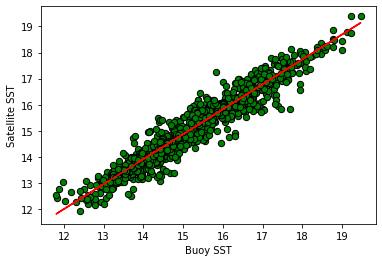

In [50]:
Y_predicted=results.predict(X1_b)
plt.scatter(X1,Y1, s=40, facecolors='green', edgecolors='black')
plt.xlabel("Buoy SST")
plt.ylabel("Satellite SST")
plt.plot(X1,Y_predicted, "r")
plt.show()

# TUTORIAL END

### Below are some additional resources associated with this tutorial

## Appendix A - Get data from NDBC

In [51]:
# select buoy years
buoy_years = ['2017', '2018', '2019']
# select buoy ID
buoy_no = '46259'
# set up url parts
url_base = 'https://www.ndbc.noaa.gov/view_text_file.php?filename='
url_end = '.txt.gz&dir=data/historical/stdmet/'

for i in range(0, len(buoy_years)):
    buoy_url = ''.join([url_base, buoy_no, 'h', buoy_years[i], url_end])
    response = requests.get(buoy_url).content
    print('Got', buoy_years[i])
    if i == 0:
        #print('N')
        buoy_df = pd.read_csv(io.StringIO(response.decode('utf-8')), skiprows=[1], sep=' ', skipinitialspace=True)
        continue
    else:
        #print('Y')
        temp_df = pd.read_csv(io.StringIO(response.decode('utf-8')), skiprows=[1], sep=' ', skipinitialspace=True)
        buoy_df = buoy_df.append(temp_df, ignore_index=True)
        
buoy_df.head()

Got 2017
Got 2018
Got 2019


,#YY,MM,DD,hh,mm,WDIR,WSPD,GST,WVHT,DPD,APD,MWD,PRES,ATMP,WTMP,DEWP,VIS,TIDE
0,2017,1,1,0,0,999,99.0,99.0,2.99,11.76,8.76,317,9999.0,999.0,13.1,999.0,99.0,99.0
1,2017,1,1,0,30,999,99.0,99.0,3.00,12.50,8.91,313,9999.0,999.0,13.0,999.0,99.0,99.0
2,2017,1,1,1,0,999,99.0,99.0,3.14,11.11,9.05,307,9999.0,999.0,13.0,999.0,99.0,99.0
3,2017,1,1,1,30,999,99.0,99.0,3.36,12.50,9.46,302,9999.0,999.0,13.0,999.0,99.0,99.0
4,2017,1,1,2,0,999,99.0,99.0,3.12,11.76,9.28,313,9999.0,999.0,13.0,999.0,99.0,99.0


__Edit the dataframe to include only the needed columns__

In [52]:
buoy_df = buoy_df[['#YY', 'MM', 'DD', 'hh', 'mm', 'WTMP']]
buoy_df.head()

,#YY,MM,DD,hh,mm,WTMP
0,2017,1,1,0,0,13.1
1,2017,1,1,0,30,13.0
2,2017,1,1,1,0,13.0
3,2017,1,1,1,30,13.0
4,2017,1,1,2,0,13.0


__Set up a dictionary to rename the date/time columns__

In [53]:
rename_dict = dict(zip(['#YY', 'MM', 'DD', 'hh', 'mm'], ('year', 'month', 'day', 'hour', 'minute')))
rename_dict

{'#YY': 'year', 'MM': 'month', 'DD': 'day', 'hh': 'hour', 'mm': 'minute'}

__Use the date columns to create a date object column__  
Put the date object column in the index position

In [54]:
#buoy_df.index = pd.to_datetime(buoy_df[['#YY', 'MM', 'DD', 'hh', 'mm']].rename(columns=mapper))
#df1
buoy_df.index = pd.to_datetime(buoy_df[['#YY', 'MM', 'DD', 'hh', 'mm']].rename(columns=rename_dict))
buoy_df

,#YY,MM,DD,hh,mm,WTMP
2017-01-01 00:00:00,2017,1,1,0,0,13.1
2017-01-01 00:30:00,2017,1,1,0,30,13.0
2017-01-01 01:00:00,2017,1,1,1,0,13.0
2017-01-01 01:30:00,2017,1,1,1,30,13.0
2017-01-01 02:00:00,2017,1,1,2,0,13.0
...,...,...,...,...,...,...
2019-12-31 21:30:00,2019,12,31,21,30,14.0
2019-12-31 22:00:00,2019,12,31,22,0,14.1
2019-12-31 22:30:00,2019,12,31,22,30,14.1
2019-12-31 23:00:00,2019,12,31,23,0,14.1


__Remove the unneeded columns from the dataframe__

In [55]:
#buoy_df = buoy_df[['#YY', 'MM', 'DD', 'hh', 'mm', 'WTMP']]
buoy_df.drop(['#YY','MM', 'DD', 'hh', 'mm'], axis=1, inplace=True)
buoy_df

,WTMP
2017-01-01 00:00:00,13.1
2017-01-01 00:30:00,13.0
2017-01-01 01:00:00,13.0
2017-01-01 01:30:00,13.0
2017-01-01 02:00:00,13.0
...,...
2019-12-31 21:30:00,14.0
2019-12-31 22:00:00,14.1
2019-12-31 22:30:00,14.1
2019-12-31 23:00:00,14.1


In [56]:
buoy_data

,Time,WTMP_degC
0,2017-01-01 00:00:00,13.1
1,2017-01-01 00:30:00,13.0
2,2017-01-01 01:00:00,13.0
3,2017-01-01 01:30:00,13.0
4,2017-01-01 02:00:00,13.0
...,...,...
50895,2019-12-31 21:30:00,14.0
50896,2019-12-31 22:00:00,14.1
50897,2019-12-31 22:30:00,14.1
50898,2019-12-31 23:00:00,14.1
